In [1]:
import numpy as np
import pandas as pd
import os

import torch
import torch.nn.functional as F
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

from LeNet5 import LeNet5
from BayesLeNet5 import BayesLeNet5
from utils import confidence_score

In [2]:
matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['lines.linewidth'] = 1.5
fig_scale = 6

## Data generation

In [4]:
batch_size = 1024
test_dataset = MNIST(
    root="data/MNIST",
    train=False, 
    transform=transforms.ToTensor()
)
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    pin_memory=True
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = BayesLeNet5()
model.to(device)
checkpoint = torch.load('models/bayeslenet5.pt')
model.load_state_dict(checkpoint['state_dict'])

n_samples = 100
output_samples = np.empty((n_samples, len(test_dataset), 10))
with torch.no_grad():
    for i, (input, _) in enumerate(test_loader):
        input = input.to(device)
        for j in range(n_samples):
            start = i * batch_size
            end = start + input.size()[0]
            output_samples[j, start:end, :] = F.softmax(model(input), dim=1).cpu().numpy()
            
labels_samples = np.argmax(output_samples, 2)
accuracy_samples = (labels_samples == test_dataset.targets.numpy())
accuracy_samples = accuracy_samples.sum(axis=1)
accuracy_samples = accuracy_samples * 100 / len(test_dataset)
outputs_B = output_samples.mean(axis=0)
confidence_B = confidence_score(output_samples)
labels_B = np.argmax(outputs_B, axis=1)
mask_correct_B = (labels_B == test_dataset.targets.numpy())

model = LeNet5()
model.to(device)
checkpoint = torch.load('models/lenet5.pt')
model.load_state_dict(checkpoint['state_dict'])

outputs_S = np.empty((len(test_dataset), 10))

with torch.no_grad():
    for i, (input, _) in enumerate(test_loader):
        input = input.to(device)
        start = i * batch_size
        end = start + input.size()[0]
        outputs_S[start:end, :] = F.softmax(model(input), dim=1).cpu().numpy()

confidence_S = outputs_S[np.arange(len(outputs_S)), np.argmax(outputs_S, axis=1)]
labels_S = np.argmax(outputs_S, axis=1)
mask_correct_S = (labels_S == test_dataset.targets.numpy())

## Figure 1a

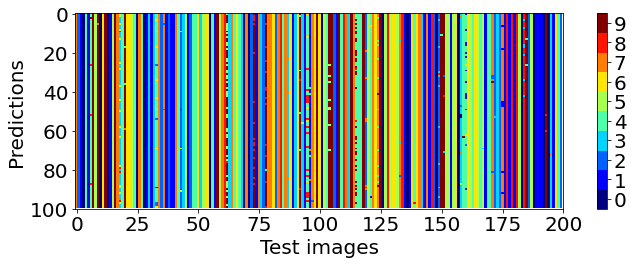

In [6]:
plt.figure(figsize=(2*fig_scale, 0.6*fig_scale))

cmap = plt.get_cmap('jet', 10)
norm = matplotlib.colors.BoundaryNorm(np.arange(-0.5, 10.5), cmap.N)
cax = plt.imshow(
    labels_samples[:, :200], 
    cmap=cmap, 
    norm=norm, 
    interpolation='none', 
    aspect=0.8
)
plt.colorbar(cax, ticks=range(10), fraction=0.023)

plt.xlabel("Test images")
plt.ylabel("Predictions")
plt.xticks(np.linspace(0, 200, 9))
plt.yticks(np.linspace(0, 100, 6))

#plt.savefig('figure1a.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## Figure 1b

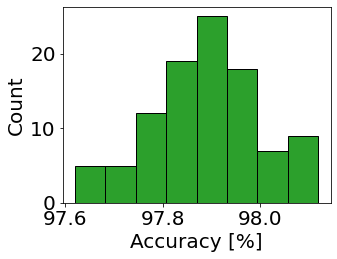

In [7]:
plt.figure(figsize=(0.8*fig_scale, 0.6*fig_scale))

plt.hist(
    accuracy_samples, 
    bins='auto', 
    edgecolor='black', 
    linewidth=1, 
    color='tab:green'
)
plt.xlabel("Accuracy [%]")
plt.ylabel("Count")

#plt.savefig('figure1b.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## Figure 1c

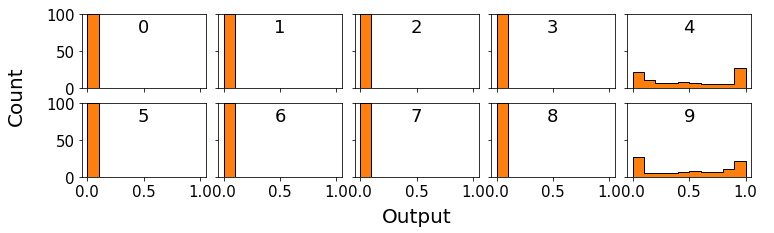

In [8]:
sample_index = 2447
fig, axes = plt.subplots(
    2, 5, 
    figsize=(2*fig_scale, 0.5*fig_scale), 
    sharex=True, sharey=True
)

for i, ax in enumerate(axes[:, :5].reshape(-1)):
    ax.hist(
        output_samples[:, sample_index, i], 
        range=(0, 1), 
        histtype='stepfilled', 
        color='tab:orange', 
        edgecolor='black', 
        linewidth=1
    )
    ax.set_xticks([0, 0.5, 1])
    ax.set_ylim(0, 100)
    ax.text(
        .5,.75, i,
        horizontalalignment='center',
        transform=ax.transAxes,
        size=18
    )

    ax.tick_params(axis='both', which='major', labelsize=15)

fig.add_subplot(111, frameon=False)
plt.tick_params(
    labelcolor='none', 
    top=False, 
    bottom=False, 
    left=False, 
    right=False
)
plt.xlabel("Output")
plt.ylabel("Count")

plt.subplots_adjust(wspace=0.1, hspace=0.2)
#plt.savefig('figure1c.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## Figure 1d

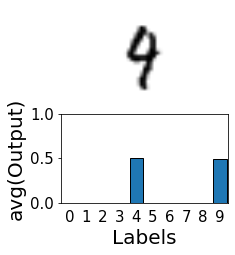

In [9]:
sample_index = 2447
_, axes = plt.subplots(
    2, 1, 
    figsize=(0.5*fig_scale, 0.6*fig_scale)
)

axes[0].imshow(
    ~test_dataset.data.numpy()[sample_index], 
    interpolation='bilinear', 
    cmap = 'gray'
)
axes[0].set_xlim(0, 28)
axes[0].axis('off')

axes[1].bar(
    np.arange(10), 
    outputs_B[sample_index], 
    color='tab:blue', 
    align='center', 
    edgecolor='black', 
    linewidth=1
)
axes[1].set_xlim(-0.5, 9.5)
axes[1].set_ylim(0, 1)
axes[1].tick_params(
    top=False, 
    bottom=False, 
    right=False, 
    left=True
)
axes[1].set_xticks(np.arange(10))
axes[1].set_yticks(np.arange(0, 1.5, 0.5))
axes[1].set_xlabel("Labels")
axes[1].tick_params(axis='both', which='major', labelsize=15)
axes[1].set_ylabel("avg(Output)")

#plt.savefig('figure1d.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

## Figure 1e

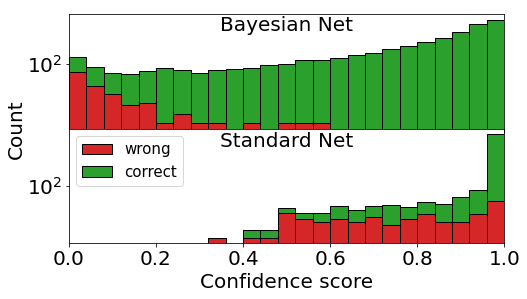

In [10]:
fig, ax = plt.subplots(
    2, 1, 
    figsize=(1.3*fig_scale,0.7*fig_scale), 
    sharex=True
)

ax[0].hist(
    [confidence_B[~mask_correct_B], 
     confidence_B[mask_correct_B]], 
    bins=25, 
    color=['tab:red', 'tab:green'], 
    histtype='barstacked', 
    log=True, 
    range=[0, 1], 
    edgecolor='black'
)
ax[0].text(
    .5,.86,
    'Bayesian Net',
    horizontalalignment='center',
    transform=ax[0].transAxes
)

ax[1].hist(
    [confidence_S[~mask_correct_S], 
     confidence_S[mask_correct_S]],
    bins=25, 
    color=['tab:red', 'tab:green'], 
    histtype='barstacked', 
    log=True, 
    range=[0, 1], 
    edgecolor='black', 
    label=['wrong', 'correct']
)
ax[1].text(
    .5,.84,
    'Standard Net',
    horizontalalignment='center',
    transform=ax[1].transAxes
)
ax[1].legend(prop={'size': 15})
ax[1].set_xlim(0, 1)

fig.add_subplot(111, frameon=False)
plt.tick_params(
    labelcolor='none', 
    top=False, 
    bottom=False, 
    left=False, 
    right=False
)
plt.xlabel("Confidence score")
plt.ylabel("Count")

plt.subplots_adjust(wspace=0, hspace=0)
#plt.savefig('figure1e.pdf', format='pdf', transparent=True, dpi=300, bbox_inches='tight')
plt.show()

## Figure 1f

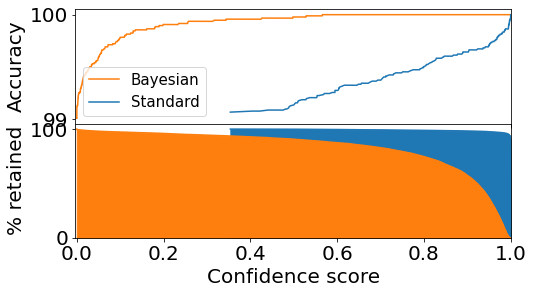

In [11]:
accuracies_B = []
perc_retain_B = []
for c in np.unique(confidence_B):
    mask = (confidence_B >= c)
    acc = np.sum(labels_B[mask] == test_dataset.targets.numpy()[mask])
    acc = acc * 100.0 / mask.sum()
    accuracies_B.append(acc)
    perc_retain_B.append(mask.sum()*100.0/len(mask))

accuracies_S = []
perc_retain_S = []
for c in np.unique(confidence_S):
    mask = (confidence_S >= c)
    acc = np.sum(labels_S[mask] == test_dataset.targets.numpy()[mask])
    acc = acc * 100.0 / mask.sum()
    accuracies_S.append(acc)
    perc_retain_S.append(mask.sum()*100.0/len(mask)) 

fig, ax = plt.subplots(
    2, 1, 
    figsize=(1.3*fig_scale,0.7*fig_scale), 
    sharex=True
)
ax[0].plot(
    np.unique(confidence_B), 
    accuracies_B, 
    color='tab:orange', 
    label='Bayesian'
)
ax[0].plot(
    np.unique(confidence_S), 
    accuracies_S, 
    color='tab:blue', 
    label='Standard'
)

ax[1].plot(
    np.unique(confidence_S), 
    perc_retain_S, 
    color='tab:blue'
)
ax[1].fill_between(
    np.unique(confidence_S), 
    perc_retain_S, 
    color='tab:blue'
)
ax[1].plot(
    np.unique(confidence_B), 
    perc_retain_B, 
    color='tab:orange'
)
ax[1].fill_between(
    np.unique(confidence_B), 
    perc_retain_B, 
    color='tab:orange'
)

ax[1].set_ylim(0, 105)
ax[1].set_xlim(0, 1.01)

ax[1].set_ylim(0, 105)
ax[1].set_xlim(-0.003, 1)
ax[1].set_xlabel("Confidence score")
ax[1].set_ylabel("% retained")
ax[0].set_ylabel("Accuracy")
ax[0].legend(
    prop={'size': 15},
    loc='lower left'
)

plt.subplots_adjust(hspace=0)
#plt.savefig('figure1f.pdf', format='pdf', transparent=True, dpi=300, bbox_inches='tight')
plt.show()

# Figure 1g

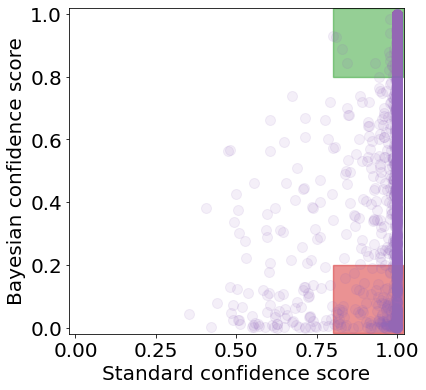

In [12]:
_, ax = plt.subplots(
    figsize=(1*fig_scale, 1*fig_scale)
)

ax.scatter(
    confidence_S, 
    confidence_B, 
    s=100, 
    c='tab:purple', 
    alpha=0.1
)
rect = Rectangle(
    (0.8,-0.018),
    0.218, 0.218,
    linewidth=1.4, 
    edgecolor='tab:red', 
    facecolor='tab:red', 
    zorder=-1, 
    alpha=0.5
)
ax.add_patch(rect)
rect = Rectangle(
    (0.8,0.8),
    0.218, 0.218,
    linewidth=1.4, 
    edgecolor='tab:green', 
    facecolor='tab:green', 
    zorder=-1, 
    alpha=0.5
)
ax.add_patch(rect)

ax.set_xlim(-0.02, 1.02)
ax.set_ylim(-0.02, 1.02)
ax.set_xlabel('Standard confidence score')
ax.set_ylabel('Bayesian confidence score')

#plt.savefig('figure1g.pdf', format='pdf', transparent=True, dpi=300, bbox_inches='tight')
plt.show()

# Figure 1h

In [13]:
def show_images(images, labels, targets, outputs, mask, n=30):

    n = min(np.sum(mask), n)
    if n == 0:
        print('The mask is too strict, no images found.')
        return
    
    indeces = np.argwhere(mask)
    images = images[mask][:n]
    labels = labels[mask][:n]
    targets = targets[mask][:n]
    outputs = outputs[mask][:n]
    
    n_columns = 10 if n > 10 else n
    n_rows = int(np.ceil(float(n)/10))
    
    _, ax = plt.subplots(2*n_rows, n_columns, figsize=(2*n_columns, 4.2*n_rows), sharey='row', squeeze=False)
    for i in range(n_rows):
        for j in range(n_columns):
            if (i*n_columns+j) >= n:
                ax[2*i][j].axis('off')
                ax[2*i+1][j].axis('off')
                continue
            
            ax[2*i][j].imshow(~images[i*10+j], interpolation='bilinear', cmap = 'gray')
            ax[2*i][j].axis('off')
            ax[2*i][j].set_title(indeces[i*10+j])
            
            colors = ["blue",] * 10
            colors[labels[i*10+j]] = "red"
            colors[targets[i*10+j]] = "green"               

            ax[2*i+1][j].bar(np.arange(10), outputs[i*10+j], color=colors, align='center')
            ax[2*i+1][j].set_xlim(-0.5, 9.5)
            ax[2*i+1][j].set_ylim(0, 1)
            #ax[2*i+1][j].spines['top'].set_visible(False)
            #ax[2*i+1][j].spines['right'].set_visible(False)
            ax[2*i+1][j].tick_params(top=False, bottom=False, right=False, left=False)
            ax[2*i+1][j].set_xticks(np.arange(10))
            ax[2*i+1][j].set_yticks(np.arange(0, 1.5, 0.5))
    plt.subplots_adjust(wspace=0.2, hspace=0.5)
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\text.py:1163: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


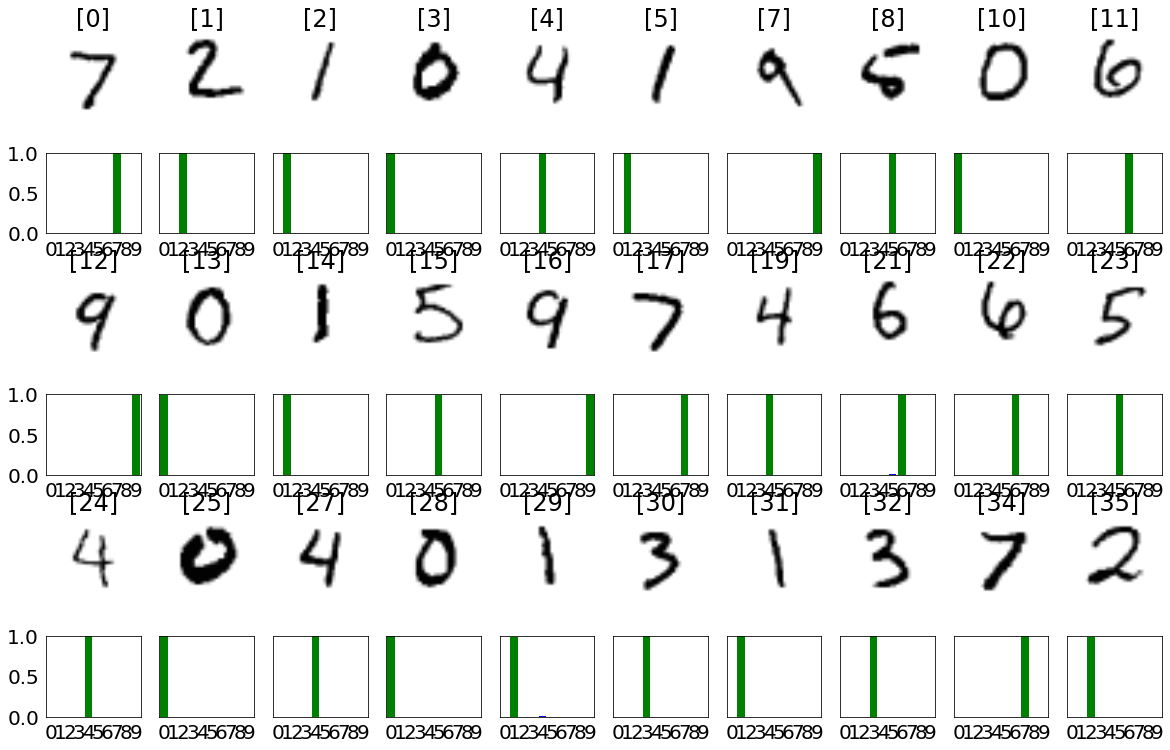

In [14]:
show_images(test_dataset.data.numpy(), 
            labels_B,
            test_dataset.targets.numpy(),
            outputs_B,
            np.logical_and((confidence_B > 0.8), (confidence_S > 0.8)))

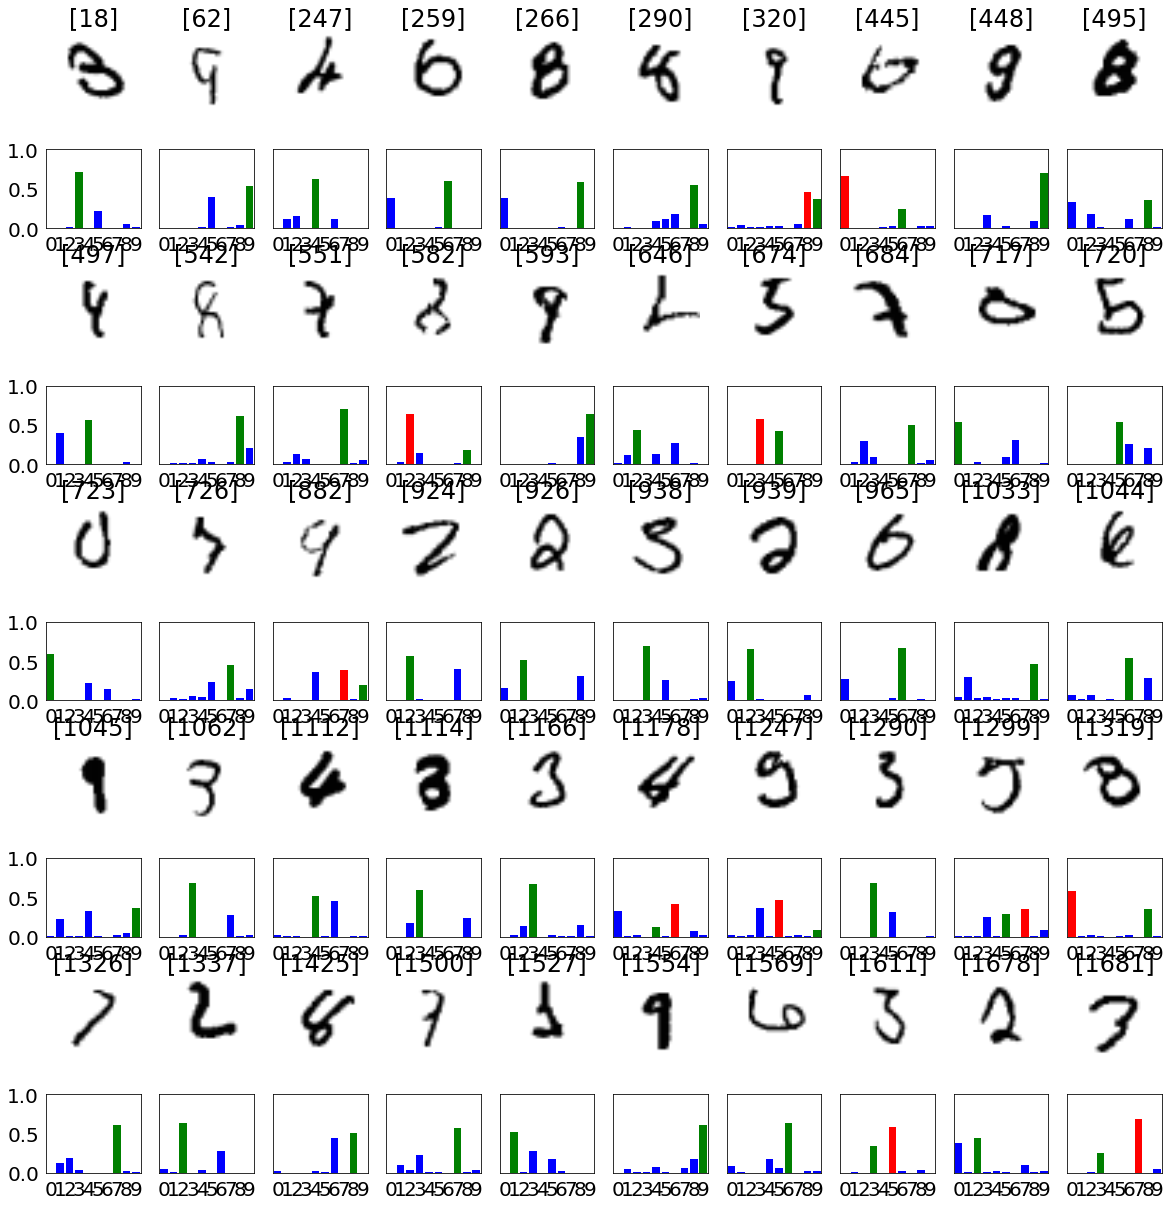

In [15]:
show_images(test_dataset.data.numpy(), 
            labels_B,
            test_dataset.targets.numpy(),
            outputs_B,
            np.logical_and((confidence_B < 0.1), (confidence_S > 0.8)), n=50)

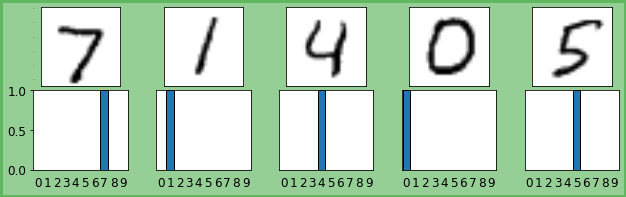

In [16]:
indeces = [0, 2, 4, 10, 23]

images = test_dataset.data.numpy()[indeces]
labels = labels_B[indeces]
targets = test_dataset.targets.numpy()[indeces]
outputs = outputs_B[indeces]

n_columns = len(indeces)
n_rows = 1

fig, ax = plt.subplots(
    2*n_rows, n_columns, 
    figsize=(1.75*fig_scale, 0.5*fig_scale), 
    sharey='row', 
    squeeze=False
)
for i in range(n_rows):
    for j in range(n_columns):
        ax[2*i][j].imshow(
            ~images[i*10+j], 
            interpolation='bilinear', 
            cmap = 'gray'
        )
        ax[2*i][j].tick_params(
            top=False, 
            bottom=False, 
            right=False, 
            left=False, 
            labelsize=0
        )
        
        ax[2*i+1][j].bar(
            np.arange(10), 
            outputs[i*10+j], 
            color='tab:blue', 
            align='center', 
            edgecolor='black', 
            linewidth=1
        )
        ax[2*i+1][j].set_xlim(-0.5, 9.5)
        ax[2*i+1][j].set_ylim(0, 1)
        
        if j == 0:
            ax[2*i+1][j].tick_params(
                top=False, 
                bottom=False, 
                right=False, 
                left=True, 
                labelsize=12
            )
        else:
            ax[2*i+1][j].tick_params(
                top=False, 
                bottom=False, 
                right=False, 
                left=False, 
                labelsize=12
            )
        ax[2*i+1][j].set_xticks(np.arange(10))
        ax[2*i+1][j].set_yticks(np.arange(0, 1.5, 0.5))

fig.patch.set_facecolor('tab:green')
fig.patch.set_edgecolor('tab:green')
fig.patch.set_linewidth(5)
fig.patch.set_alpha(0.5)
plt.subplots_adjust(wspace=0.3, hspace=0.05)
#plt.savefig('figure1h1.png', format='png', transparent=True, dpi=300, 
#            facecolor=fig.get_facecolor(), edgecolor=fig.get_edgecolor(), bbox_inches='tight')
plt.show()

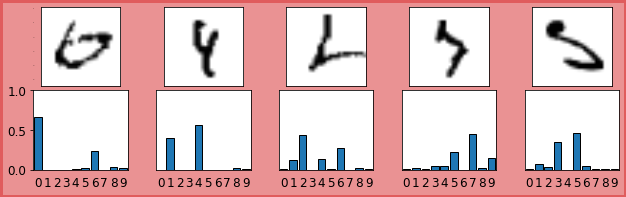

In [17]:
indeces = [445, 497, 646, 726, 1737]

images = test_dataset.data.numpy()[indeces]
labels = labels_B[indeces]
targets = test_dataset.targets.numpy()[indeces]
outputs = outputs_B[indeces]

n_columns = len(indeces)
n_rows = 1

fig, ax = plt.subplots(
    2*n_rows, n_columns, 
    figsize=(1.75*fig_scale, 0.5*fig_scale), 
    sharey='row', 
    squeeze=False
)
for i in range(n_rows):
    for j in range(n_columns):
        ax[2*i][j].imshow(
            ~images[i*10+j], 
            interpolation='bilinear', 
            cmap = 'gray'
        )
        ax[2*i][j].tick_params(
            top=False, 
            bottom=False, 
            right=False, 
            left=False, 
            labelsize=0
        )
        
        ax[2*i+1][j].bar(
            np.arange(10), 
            outputs[i*10+j], 
            color='tab:blue', 
            align='center', 
            edgecolor='black', 
            linewidth=1
        )
        ax[2*i+1][j].set_xlim(-0.5, 9.5)
        ax[2*i+1][j].set_ylim(0, 1)
        
        if j == 0:
            ax[2*i+1][j].tick_params(
                top=False, 
                bottom=False, 
                right=False, 
                left=True, 
                labelsize=12
            )
        else:
            ax[2*i+1][j].tick_params(
                top=False, 
                bottom=False, 
                right=False, 
                left=False, 
                labelsize=12
            )
        ax[2*i+1][j].set_xticks(np.arange(10))
        ax[2*i+1][j].set_yticks(np.arange(0, 1.5, 0.5))

fig.patch.set_facecolor('tab:red')
fig.patch.set_edgecolor('tab:red')
fig.patch.set_linewidth(5)
fig.patch.set_alpha(0.5)
plt.subplots_adjust(wspace=0.3, hspace=0.05)
#plt.savefig('figure1h2.png', format='png', transparent=True, dpi=300, 
#            facecolor=fig.get_facecolor(), edgecolor=fig.get_edgecolor(), bbox_inches='tight')
plt.show()